# Bridge FT Integration Example

Per:
 - https://linear.app/astrocyte/issue/AR-162/v2-api-object-clean-up
 - https://linear.app/astrocyte/issue/AR-160/bridge-integration-v2
 
## Main Objectives

1. establish baseline expected volatility of portfolio or advisor sets level
2. Identify when that level is materially breached.
3. Generate backtest that shows how taking action to move back to a target vol (risk averse model) improves performance historically and flag the dates where that action would have been taken.
4. Alert advisors on an ongoing basis when those criteria are met.

## Steps to achive objective

1. Pull in existing portfolio from Bridge System
2. Create a universe of existing holdings
3. Populate Risk Model (historical + breakpoint)
4. Bucket Portfolio and show portfolio level and bucket-level risks
5. Enable user to select portfolio level, and (optionally) bucket-level risk alerts and the risk metric they care about.
6. Highlight where in the portfolio the level is breached.
7. Identify target model portfolio and repeat step 6
8. Show risk deviations from standard model and contribution to portfolio-level and bucket-level risks

### Backtest

1. Show performance of model portfolio using the vol targeting approach (aka target vol / risk averse model) vs static model
2. Show dates with the greatest deviation in weights

### Alerts 
4. Alert advisors on an ongoing basis when those criteria are met.


## Other cool things to do

1. Identify {holding, portfolio, bucket}-level portformer replacements
1. Optimize Portfolio for {dividends, fees, volatility, return}
1. Auto generate a model portfolio
1. compare current static portfolio / model-portfolio with historical NAVs to determine how dynamic a strategy is
1. Run alert for tax optimization opportunities


In [157]:
# Bridge API
import requests
import json
import os
import urllib
import datetime

from tqdm.notebook import tqdm  # for use in notebook
# from tqdm import tqdm          # for use in scripts


class BridgeAPI:

    def __init__(self):
        self._username = None
        self._token = None
        self._refresh_token = None
        self.url_base = 'https://api.bridgeft.com'

    def login(self, username=None, password=None):
        if username is None:
            username = self.username
        else:
            self.username = username

        url = urllib.parse.urljoin(self.url_base, '/v2/oauth2/token')

        if password is None:
            password = input('password')
        body = 'username={username}&password={password}&grant_type=password'.format(username=username, password=password)
        rs = requests.post(url, headers = {
            'Content-Type': 'application/x-www-form-urlencoded'
        }, data = body)
        if rs.ok:
            content = json.loads(rs.content)
            self._token = content['IdToken']
            self._refresh_token = content['RefreshToken']
        else:
            RuntimeError('{}: {}'.format(rs.status_code, rs.content))

    def auth_header(self):
        return {"Authorization": "Bearer {}".format(self._token)}
        
    def list_households(self, bearer_token):
        url = urllib.parse.urljoin(self.url_base, '/v2/account-management/household')        
        response = requests.request("GET", url, headers=self.auth_header())
        return json.loads(response.text).get('data',[])

    def list_accounts(self, household_id=None):
        url = urllib.parse.urljoin(self.url_base, '/v2/account-management/account/filter')        
        response = requests.request("POST", url, headers=self.auth_header(), json={
             "household_id": household_id
        })
        return json.loads(response.content).get('data',[])

    def get_custodian_positions(self, household_id, page=1, page_size=1000):
        url = urllib.parse.urljoin(
            self.url_base, 
            '/v2/data/custodian/position?household_id={household_id}&page={page}&page_size={page_size}'.format(
                household_id=household_id,
                page=page,
                page_size=page_size
            )
        )
        response = requests.request("GET", url, headers=bridge.auth_header())
        obj = json.loads(response.content)
        return pd.DataFrame(obj.get('data',[])), obj['has_next'], obj.get('total_pages', 1)

    def yield_custodian_positions(self, household_id, page=1, page_size=1000, ittr=None):        
        has_next = True        
        while has_next:
            positions, has_next, total_pages = self.get_custodian_positions(household_id, page=page, page_size=page_size)
            yield positions

            page += 1
            if ittr is None:
                ittr = tqdm(total=total_pages)
            ittr.update(1)


bridge = BridgeAPI()
bridge.login(username='skruzel@portformer.com', password='B0stonYou\'reMyHome')

In [158]:
households = pd.DataFrame(bridge.list_households(token)).set_index('id').sort_index()

display(households)

household_id = 2972 # Mike & Molly Matthews
assert household_id in households.index, "Mike & Molly Matthews id not found"

,managing_firm_id,short_name,object,is_account,status,opening_date,close_date,entity_id,inception_date,benchmarks_id_list,is_household,firm_ids,name
id,,,,,,,,,,,,,
2969,39,DEMMLH,account_management.household,False,110,2017-06-30,None,H-DEMMLH,2016-12-31,"[9394, 9581]",True,"[39, 315]",Eddie & Emily Edwards Household
2972,39,DEMGXH,account_management.household,False,110,2017-06-30,None,H-DEMGXH,2016-12-31,"[9393, 9394, 10385]",True,"[39, 315]",Mike & Molly Matthews Household
2974,39,DEMBBH,account_management.household,False,110,2017-06-30,None,H-DEMBBH,2015-09-30,"[9581, 9730]",True,"[39, 315]",Jim & Janet Jones Household
3236,39,DEMTTH,account_management.household,False,110,2017-08-25,None,H-DEMTTH,2016-11-18,"[9394, 9581]",True,"[39, 315]",John & Jane Johnson Household
11292,39,DEMSHH,account_management.household,False,110,2018-12-31,None,H-DEMSHH,2015-12-31,"[9394, 9581]",True,"[39, 315]",Ryan & Jasmine Smith Household
12281,39,HHDDTC,account_management.household,False,110,2019-04-30,None,H-HHDDTC,2019-04-30,"[9394, 9581, 9882]",True,"[39, 315]",Demo Account Household
17964,39,FLOCHE,account_management.household,False,110,None,None,H-FLOCHE,None,[9394],True,"[39, 315]",Chelsea Flood Household
20870,39,FADA877E,account_management.household,False,110,2020-08-05,None,H-FADA877E,2020-08-05,[],True,"[39, 315]",LUCA Test Household


In [159]:
# Get historical positions
data_columns = [
    'market_price',  'original_face',  'current_yield',  'accrued_income',  'quantity', 'market_value',  'cost'
]
date_columns = [
    'settle_date', 'as_of_date', 'purchase_date'
]
positions = pd.concat([p for p in bridge.yield_custodian_positions(household_id)], axis=0, ignore_index=True)
positions.loc[:, data_columns] = positions.loc[:, data_columns].astype(np.float)

for c in date_columns:
    positions.loc[:, c] = positions.loc[:, c].apply(
        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') if x is not None else None
    )

<AxesSubplot:xlabel='as_of_date'>

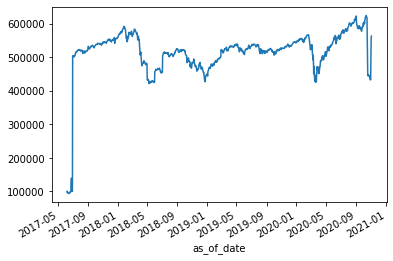

In [215]:
market_values = pd.pivot_table(
    positions, 
    index='as_of_date', 
    columns=['security_id','symbol'], 
    values='market_value'
).sort_index()

market_values.sum(axis=1).plot()

In [205]:
latest_as_of_date = positions.as_of_date.max()
latest_as_of_date

Timestamp('2020-11-03 00:00:00')

In [206]:
latest_positions = positions.loc[positions.as_of_date == latest_as_of_date]
latest_positions

,object,settle_date,market_price,account_id,original_face,current_yield,accrued_income,as_of_date,cusip,quantity,symbol,id,market_value,cost,household_id,purchase_date,security_id
71919,data.custodian.position,None,100.00,None,0.0,0.00,0.0,2020-11-03,,214297.03,CASH-1,4458688102,214297.03,214297.03,2972,None,5217
71920,data.custodian.position,2018-05-14 00:00:00,15.13,None,0.0,0.00,0.0,2020-11-03,002896207,110.00,ANF,4458688103,1664.30,2881.35,2972,2018-05-10 00:00:00,163
71921,data.custodian.position,2018-05-14 00:00:00,260.80,None,0.0,0.00,0.0,2020-11-03,003654100,9.00,ABMD,4458688104,2347.20,3312.16,2972,2018-05-10 00:00:00,4926
71922,data.custodian.position,2018-05-14 00:00:00,454.02,None,0.0,0.00,0.0,2020-11-03,00724F101,12.00,ADBE,4458688105,5448.24,2893.03,2972,2018-05-10 00:00:00,1768
71923,data.custodian.position,2018-05-14 00:00:00,36.49,None,0.0,0.00,0.0,2020-11-03,06684L103,54.00,BZUN,4458688106,1970.46,2730.25,2972,2018-05-10 00:00:00,897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72031,data.custodian.position,2018-05-14 00:00:00,118.21,None,0.0,0.47,0.0,2020-11-03,974155103,6.00,WING,4458691718,709.26,321.53,2972,2018-05-10 00:00:00,1832
72032,data.custodian.position,2018-05-14 00:00:00,38.50,None,0.0,1.25,0.0,2020-11-03,98156Q108,68.00,WWE,4458691719,2618.00,2952.84,2972,2018-05-10 00:00:00,3837
72033,data.custodian.position,2018-05-14 00:00:00,38.50,None,0.0,1.25,0.0,2020-11-03,98156Q108,7.00,WWE,4458693571,269.50,303.97,2972,2018-05-10 00:00:00,3837
72034,data.custodian.position,2018-05-14 00:00:00,114.66,None,0.0,0.00,0.0,2020-11-03,98936J101,52.00,ZEN,4458693572,5962.32,2954.97,2972,2018-05-10 00:00:00,16877


In [229]:
# Get latest prices
market_price = latest_positions.groupby(
    ['security_id','symbol']
)['market_price'].mean()
market_price.name = 'market_price'

# Get lot counts
latest_lot_counts = latest_positions.groupby(
    ['security_id','symbol']
)['quantity'].count()
latest_lot_counts.name = 'lot_counts'
latest_lot_counts

latest_holdings = latest_positions.groupby(
    ['security_id','symbol']
)[['quantity', 'market_value', 'cost']].sum().sort_values(['market_value'])

latest_holdings = latest_holdings.join(latest_lot_counts, how='left').join(market_price, how='left')

display(latest_holdings)

,,quantity,market_value,cost,lot_counts,market_price
security_id,symbol,,,,,
5578,TLRDQ,91.00,6.82,2885.38,1,0.07
16870,DNRCQZ,765.00,22.95,2889.54,1,0.03
10800,WLL--Z,68.00,38.52,3212.69,2,0.57
1756,HFC,43.00,819.15,2916.10,1,19.05
5860,TWOU,34.00,1279.76,3229.59,2,37.64
16872,HRTX,96.00,1560.96,2903.05,1,16.26
1484,GES,123.00,1583.01,2919.38,1,12.87
10455,SPYV,52.00,1600.04,1622.21,4,30.77
163,ANF,110.00,1664.30,2881.35,1,15.13


In [217]:
latest_positions

,object,settle_date,market_price,account_id,original_face,current_yield,accrued_income,as_of_date,cusip,quantity,symbol,id,market_value,cost,household_id,purchase_date,security_id
71919,data.custodian.position,None,100.00,None,0.0,0.00,0.0,2020-11-03,,214297.03,CASH-1,4458688102,214297.03,214297.03,2972,None,5217
71920,data.custodian.position,2018-05-14 00:00:00,15.13,None,0.0,0.00,0.0,2020-11-03,002896207,110.00,ANF,4458688103,1664.30,2881.35,2972,2018-05-10 00:00:00,163
71921,data.custodian.position,2018-05-14 00:00:00,260.80,None,0.0,0.00,0.0,2020-11-03,003654100,9.00,ABMD,4458688104,2347.20,3312.16,2972,2018-05-10 00:00:00,4926
71922,data.custodian.position,2018-05-14 00:00:00,454.02,None,0.0,0.00,0.0,2020-11-03,00724F101,12.00,ADBE,4458688105,5448.24,2893.03,2972,2018-05-10 00:00:00,1768
71923,data.custodian.position,2018-05-14 00:00:00,36.49,None,0.0,0.00,0.0,2020-11-03,06684L103,54.00,BZUN,4458688106,1970.46,2730.25,2972,2018-05-10 00:00:00,897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72031,data.custodian.position,2018-05-14 00:00:00,118.21,None,0.0,0.47,0.0,2020-11-03,974155103,6.00,WING,4458691718,709.26,321.53,2972,2018-05-10 00:00:00,1832
72032,data.custodian.position,2018-05-14 00:00:00,38.50,None,0.0,1.25,0.0,2020-11-03,98156Q108,68.00,WWE,4458691719,2618.00,2952.84,2972,2018-05-10 00:00:00,3837
72033,data.custodian.position,2018-05-14 00:00:00,38.50,None,0.0,1.25,0.0,2020-11-03,98156Q108,7.00,WWE,4458693571,269.50,303.97,2972,2018-05-10 00:00:00,3837
72034,data.custodian.position,2018-05-14 00:00:00,114.66,None,0.0,0.00,0.0,2020-11-03,98936J101,52.00,ZEN,4458693572,5962.32,2954.97,2972,2018-05-10 00:00:00,16877


In [207]:
market_values.tail()

security_id 6          7                8              11                    \
symbol             IVV              IWP            IWO                  VTI   
as_of_date                                                                    
2020-10-29     NaN NaN    NaN  13666.35    NaN  6824.1    NaN  12655.406667   
2020-10-30     NaN NaN    NaN  13413.70    NaN  6695.1    NaN  12521.190000   
2020-10-31     NaN NaN    NaN  13413.70    NaN  6695.1    NaN  12521.190000   
2020-11-02     NaN NaN    NaN  13508.25    NaN  6788.4    NaN  17121.455000   
2020-11-03     NaN NaN    NaN  13808.95    NaN  6993.0    NaN  17450.225000   

security_id 13          ... 16870     16871    16872     16873    16874   \
symbol             BND  ... DNRCQZ       HAE     HRTX       PEN     PSTG   
as_of_date              ...                                                
2020-10-29     NaN NaN  ...  12.75  2032.875   850.12  2773.890  1174.55   
2020-10-30     NaN NaN  ...  12.75  1971.255   864.43  2740.815  1118.95   
2020-10-31     NaN NaN  ...  12.75  1971.255   864.43  2740.815  1118.95   
2020-11-02     NaN NaN  ...  22.95  3661.200  1569.60  4715.230  2089.08   
2020-11-03     NaN NaN  ...  22.95  3679.200  1560.96  4744.110  2130.66   

security_id   16875  16876            16877     329924  
symbol           RNG   SFLY SFLY-Z       ZEN       JNK  
as_of_date                                              
2020-10-29   5188.17    NaN    NaN  3021.855  5117.265  
2020-10-30   5037.63    NaN    NaN  3161.790  5128.080  
2020-10-31   5037.63    NaN    NaN  3161.790  5128.080  
2020-11-02   9271.80    NaN    NaN  3134.145  5118.740  
2020-11-03   9252.36    NaN    NaN  3267.810  5167.415  

[5 rows x 165 columns]

In [197]:


# positions.loc[:, ['object', 'settle_date', 'account_id',  'as_of_date', 'purchase_date']]

<AxesSubplot:xlabel='as_of_date'>

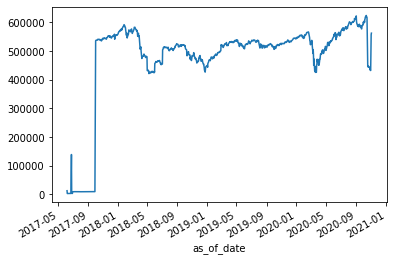

In [198]:
market_values.fillna(0).sum(axis=1).plot(legend=False)

In [173]:
positions.market_value.astype(np.float).sum()

705104743.6099999

In [170]:
import numpy as np

In [108]:
import requests

url = "https://api.bridgeft.com/v2/data/luca/holding"

headers = {"Authorization": "Bearer {}".format(bridge._token)}

response = requests.request("GET", url, headers=bridge.auth_header())

print(response.text)

{"message": "Internal server error"}


In [109]:
accounts = pd.DataFrame(bridge.list_accounts(household_id))

In [110]:
accounts.T

,0,1,2,3,4
object,account_management.account,account_management.account,account_management.account,account_management.account,account_management.account
display_name,Matt Education Savings Account,Molly Roth IRA,Mike & Molly JTWROS,Mike IRA,Mike Rollover IRA
household_id,2972,2972,2972,2972,2972
city,,,,,
number,95687553,87887459,75752549,55859583,97314989
firm_ids,"[39, 315]","[39, 315]","[39, 315]","[39, 315]","[39, 315]"
state,,,,,
is_active,True,True,True,True,True
is_composite,None,None,None,None,None
acct_type,Education Savings Account,Roth IRA,JTWROS,IRA,Rollover IRA


In [114]:
benchmarks_id = 10312
account_number = 95687553

In [16]:
from typing import Dict
import pandas as pd

class RiskBounds(object):
    pass

class Portfolio(object):
    pass 

class ModelPortfolio(object):
    pass

class RiskModel(object):
    pass

In [17]:
def create_model_from_portfolio(portfolio: Portfolio) -> ModelPortfolio:
    raise NotImplementedError()

    

In [18]:
# 1. Pull in existing portfolio from Bridge System

def step1_pull_account_info_from_bridge():
    """Given account information returns a portfolio"""
    raise NotImplementedError()
    
def step2_create_universe_from_portfolio_holdings(portfolio):
    """Given a Portfolio object and source parameters, returns a Universe with FastFunds of HLOCV and total return data"""
    raise NotImplementedError()
    
def step3_create_risk_models(portfolio, universe):
    bp_risk = BreakpointRiskModel(portfolio, universe)
    hist_risk = HistoricalRiskModel(portfolio, universe)
    return bp_risk, hist_risk

def step4_bucket_portfolio(portfolio, risk_model):
    """Bucket Portfolio and show portfolio level and bucket-level risks using hrp"""
    raise NotImplementedError()



def step5_portfolio_set_risk_limits(portfolio_with_buckets, risk_model) -> (str, Dict[str, RiskBounds]):
    """Enable user to select portfolio level, and (optionally) bucket-level 
    risk alerts and the risk metric they care about."""
    portfolio_risk_limit: RiskBounds = None

    risk_metric: str = None
    risk_limits: Dict[str, RiskBounds] = {
        '_portfolio': RiskBounds(),
        '_position': RiskBounds()
    }
    for bucket in portfolio_with_buckets.buckets:
        risk_limits[bucket] = RiskBounds()

    return risk_metric, risk_limits


def step6_portfolio_risk_vs_limits(
    portfolio_with_buckets,
    risk_model,
    risk_metric: str,
    risk_limits: Dict[str, RiskBounds],
    target_model: ModelPortfolio = None
):
    """Highlight where in the portfolio the level is breached."""
    if target_model is None:
        target_model = create_model_from_portfolio(portfolio)
    raise NotImplementedError()
    
    
def step8_risk_statistics(
    portfolio_with_buckets: Portfolio,
    risk_model: RiskModel,
    risk_metric: str,
    risk_limits: RiskBounds,
    target_model: ModelPortfolio = None
) -> pd.DataFrame:
    """Show risk deviations from standard model and contribution to portfolio-level
    and bucket-level risks"""
    raise NotImplementedError()
    


In [21]:
# Bridge Example
portfolio = step1_pull_account_info_from_bridge()    
universe = step2_create_universe_from_portfolio_holdings(portfolio)
bp_risk, hist_risk = step3_create_risk_models(portfolio, universe)
portfolio = step4_bucket_portfolio(portfolio, hist_risk)
risk_metric, risk_limits = step5_portfolio_set_risk_limits(portfolio, hist_risk)
target_model = create_model_from_portfolio(portfolio)
risk_alerts = step6_portfolio_risk_vs_limits(portfolio, hist_risk, risk_metric, risk_limits, target_model=target_model)
risk_report = step8_risk_statistics(
    portfolio,
    hist_risk,
    risk_metric,
    risk_limits, 
    target_model
    )

NotImplementedError: 